# Loading




In [1]:
# Import useful libraries
import pandas as pd
import json
import numpy as np
from numpy import fft
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale, normalize, StandardScaler

In [2]:
# Import Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# returns JSON object as a dictionary
f = open('/content/drive/MyDrive/Iceberg/train.json',) # The train.json file needs to be in an "Iceberg" directory

# creating a dataframe
df_raw = pd.DataFrame(json.load(f))

# visualising the first rows
df_raw.head()

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878361, -27.15416, -28.668615, -29.537971...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920305, -14.920363, -12.66633...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [4]:
# Visualising info
print(df_raw.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1604 entries, 0 to 1603
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          1604 non-null   object
 1   band_1      1604 non-null   object
 2   band_2      1604 non-null   object
 3   inc_angle   1604 non-null   object
 4   is_iceberg  1604 non-null   int64 
dtypes: int64(1), object(4)
memory usage: 62.8+ KB
None


# Data treatment

In [5]:
# Train/test split
df = df_raw.sample(frac = 0.8, random_state = 42)
df_test = df_raw.drop(df.index)

In [6]:
# Changing inc_angle from object to float64
df.replace('na', np.NaN, inplace = True) # Replacing the 'na' text in inc_angle by NaN
df['inc_angle'].astype('float', copy = False) # Casting inc_angle to float works with the NaN
df[df.inc_angle.isna()] # 133 NaN
print(df.info()) # inc_angle is now float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB
None


# Visualization

In [7]:
# Function to show pictures of both bands
def show_bands(row):
  f, (img1, img2) = plt.subplots(1, 2)
  img1.imshow(np.array(row.band_1).reshape(75,75))
  img1.set_title("band_1")
  img2.imshow(np.array(row.band_2).reshape(75,75))
  img2.set_title("band_2")
  plt.show()

Iceberg examples


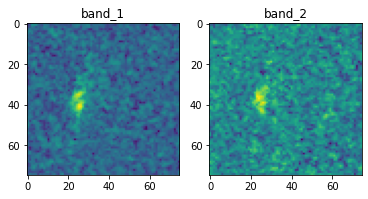

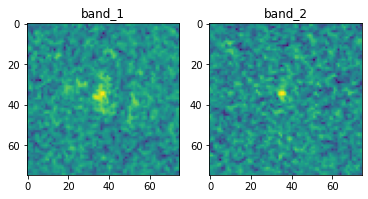

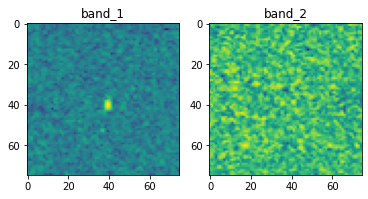

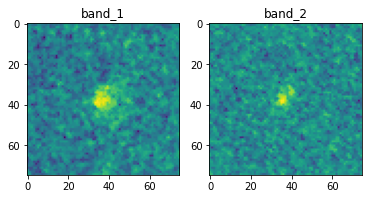

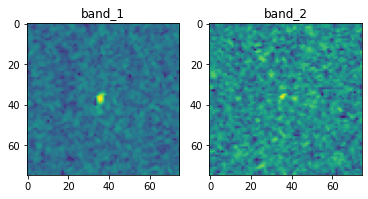

In [8]:
# 5 Iceberg examples
print("Iceberg examples")
df[df['is_iceberg'] == 1].sample(5).apply(show_bands, axis=1)
print()

Boat examples


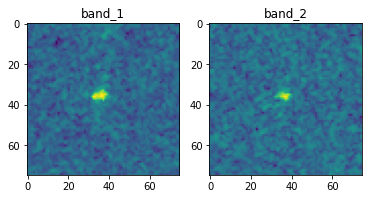

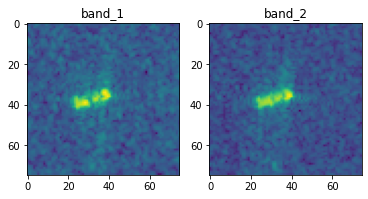

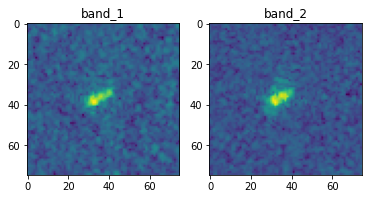

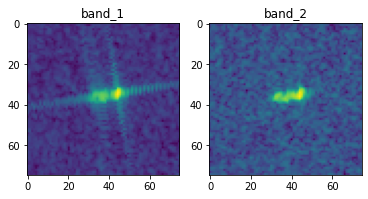

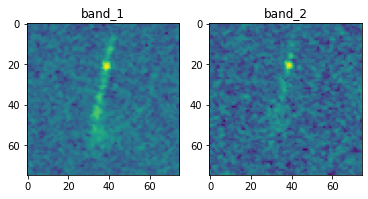

In [9]:
# 5 boat examples
print("Boat examples")
df[df['is_iceberg'] == 0].sample(5).apply(show_bands, axis=1)
print()

# Image processing

https://scikit-image.org/docs/stable/user_guide.html




In [10]:
!pip uninstall scikit-image -y

!pip install -U scikit-image


Found existing installation: scikit-image 0.16.2
Uninstalling scikit-image-0.16.2:
  Successfully uninstalled scikit-image-0.16.2
     |████████████████████████████████| 29.2 MB 82 kB/s 
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [11]:
import skimage as sk
import skimage.filters as fl
import skimage.restoration as rs
#print(skimage.__version__)

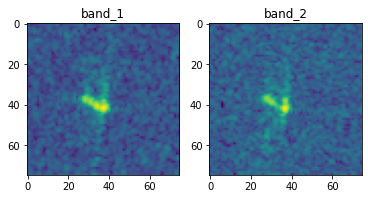

In [12]:
f, (i1, i2) = plt.subplots(1, 2)
img1 = np.array(df.iloc[4][df.columns.get_loc('band_1')]).reshape(75,75)
img2 = np.array(df.iloc[4][df.columns.get_loc('band_2')]).reshape(75,75)
i1.imshow(img1)
i1.set_title('band_1')
i2.imshow(img2)
i2.set_title('band_2')
plt.show()

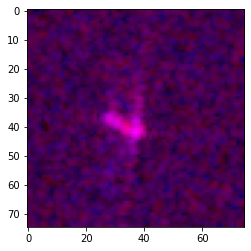

In [13]:
img1 = (img1 - img1.min())/(img1.max()-img1.min())
img2 = (img2 - img2.min())/(img2.max()-img2.min())
color = np.dstack((img1,np.zeros((75,75,1)),img2))
plt.imshow(color)

## Denoise

https://scikit-image.org/docs/dev/auto_examples/filters/plot_denoise.html

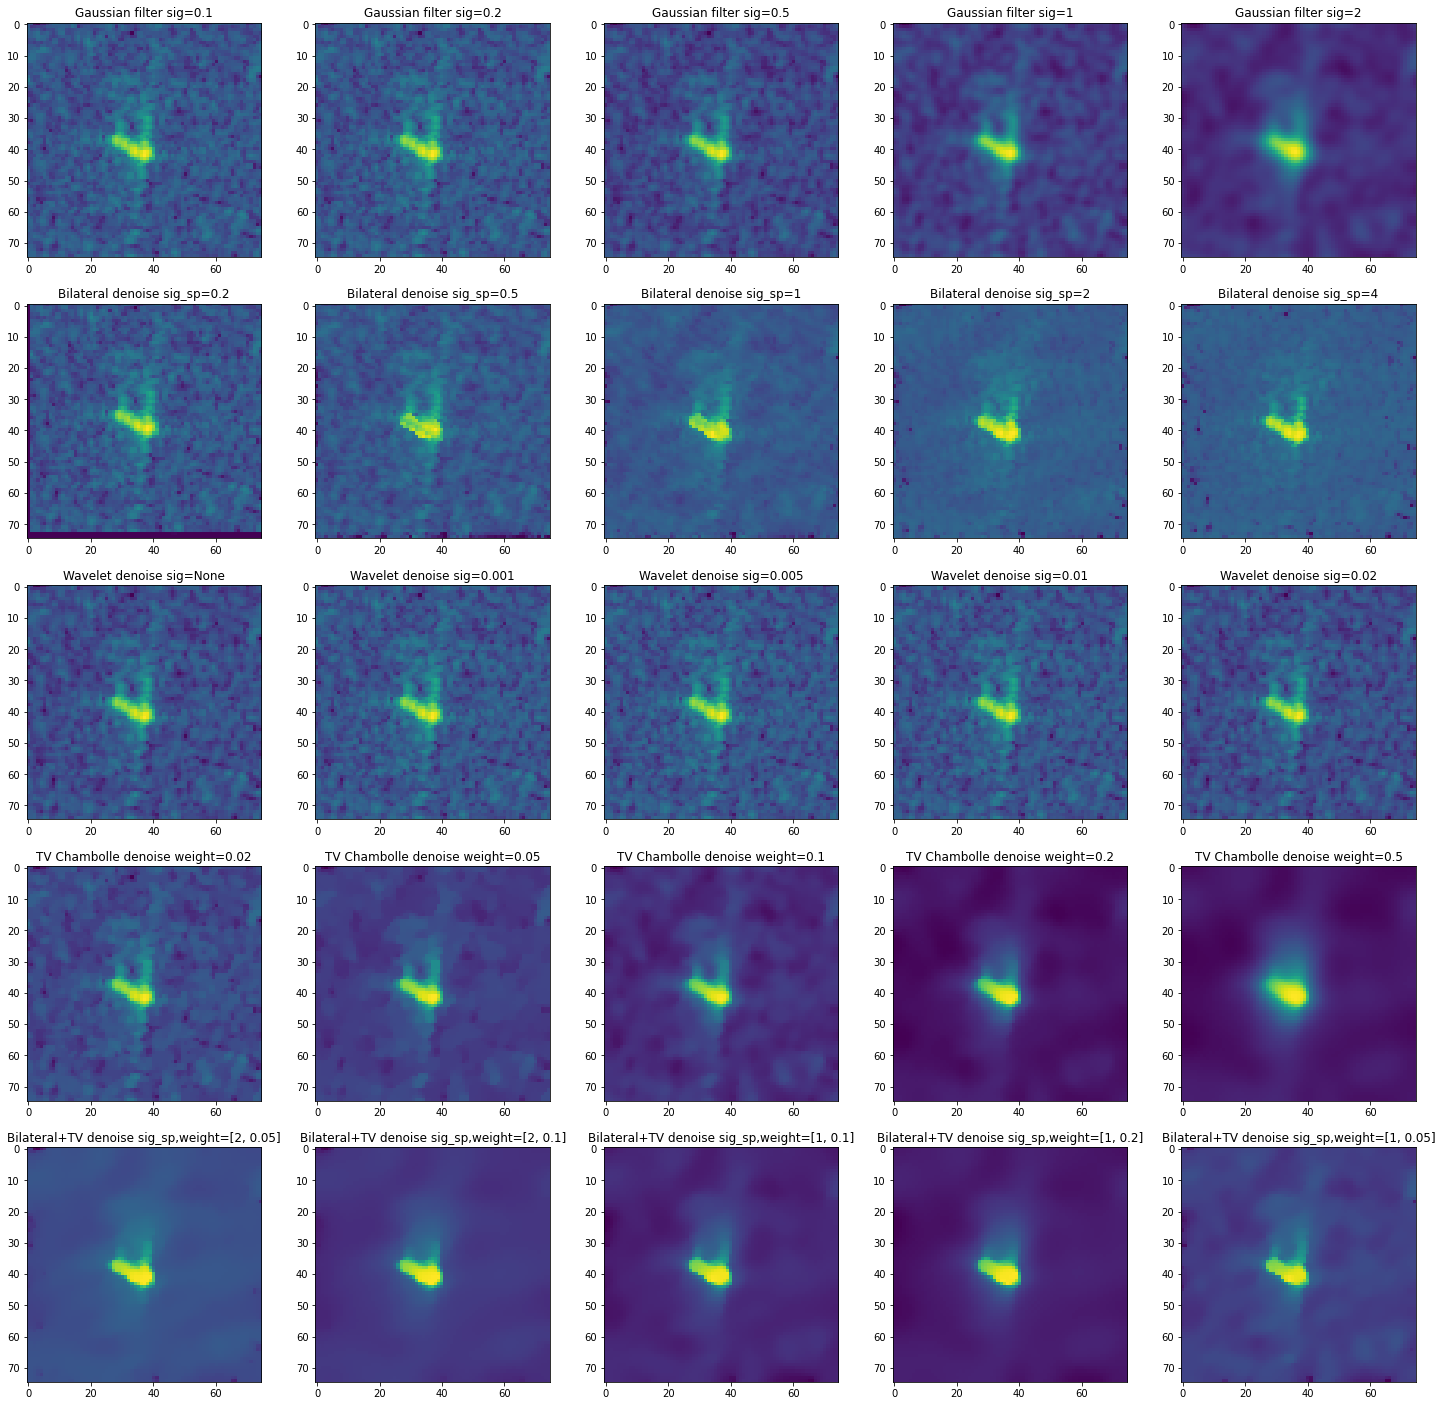

In [14]:
img = img1

f, axs = plt.subplots(5, 5, figsize=(25,25))

gaussian_sigma = [0.1, 0.2, 0.5, 1, 2] # rs.estimate_sigma(img) gives 0.02
bilateral_sigma_spatial = [0.2, 0.5, 1, 2, 4]
wavelet_sigma = [None, 0.001, 0.005, 0.01, 0.02]
tv_weight = [0.02, 0.05, 0.1, 0.2, 0.5]
bilateral_tv = [[2, 0.05],[2, 0.1],[1, 0.1],[1, 0.2],[1, 0.05]]

for i, c in enumerate(gaussian_sigma):
  axs[0][i].imshow(fl.gaussian(img, sigma = c))
  axs[0][i].set_title(f"Gaussian filter sig={c}")
for i, c in enumerate(bilateral_sigma_spatial):
  axs[1][i].imshow(rs.denoise_bilateral(img, sigma_spatial = c))
  axs[1][i].set_title(f"Bilateral denoise sig_sp={c}")
for i, c in enumerate(wavelet_sigma):
  axs[2][i].imshow(rs.denoise_wavelet(img, sigma = c, wavelet='coif1', rescale_sigma=True))
  axs[2][i].set_title(f"Wavelet denoise sig={c}")
for i, c in enumerate(tv_weight):
  axs[3][i].imshow(rs.denoise_tv_chambolle(img, weight = c))
  axs[3][i].set_title(f"TV Chambolle denoise weight={c}")
for i, c in enumerate(bilateral_tv):
  axs[4][i].imshow(rs.denoise_tv_chambolle(rs.denoise_bilateral(img, sigma_spatial = c[0]), weight = c[1]))
  axs[4][i].set_title(f"Bilateral+TV denoise sig_sp,weight={c}")

/usr/local/lib/python3.7/dist-packages/pywt/_multilevel.py:45: UserWarning:

Level value of 1 is too high: all coefficients will experience boundary effects.



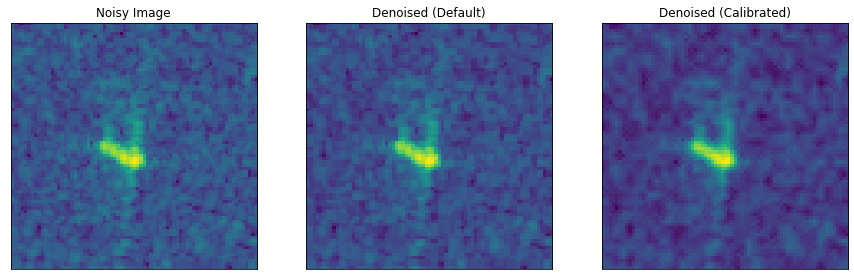

In [15]:
from functools import partial
import pywt

# rescale_sigma=True required to silence deprecation warnings
_denoise_wavelet = partial(rs.denoise_wavelet, rescale_sigma=True)

# Parameters to test when calibrating the denoising algorithm
parameter_ranges = {'sigma': np.arange(0.01, 0.1, 0.01),
                    'wavelet': ['coif1', 'coif2', 'coif3', 'coif4', 'coif5', 'coif6', 'coif7', 'coif8', 'coif9', 'coif10', 
                                'coif11', 'coif12', 'coif13', 'coif14', 'coif15', 'coif16', 'coif17', 
                                'db1', 'db2', 'db3', 'db4', 'db5', 'db6', 'db7', 'db8', 'db9', 'db10', 'db11', 'db12', 'db13', 'db14', 'db15', 
                                'db16', 'db17', 'db18', 'db19', 'db20', 'db21', 'db22', 'db23', 'db24', 'db25', 'db26', 'db27', 'db28', 'db29', 
                                'db30', 'db31', 'db32', 'db33', 'db34', 'db35', 'db36', 'db37', 'db38', 'dmey', 'haar', 
                                'sym2', 'sym3', 'sym4', 'sym5', 'sym6', 'sym7', 'sym8', 'sym9', 'sym10', 'sym11', 'sym12', 'sym13', 'sym14', 'sym15', 
                                'sym16', 'sym17', 'sym18', 'sym19', 'sym20']}

#pywt.wavelist(kind='discrete')} #['db1', 'db2']

# Denoised image using default parameters of `denoise_wavelet`
default_output = rs.denoise_wavelet(img, rescale_sigma=True)

# Calibrate denoiser
calibrated_denoiser = rs.calibrate_denoiser(img,
                                         _denoise_wavelet,
                                         denoise_parameters=parameter_ranges)

# Denoised image using calibrated denoiser
calibrated_output = calibrated_denoiser(img)

fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 5))

for ax, toprint, title in zip(
        axes,
        [img, default_output, calibrated_output],
        ['Noisy Image', 'Denoised (Default)', 'Denoised (Calibrated)']
):
    ax.imshow(toprint)
    ax.set_title(title)
    ax.set_yticks([])
    ax.set_xticks([])

In [16]:
calibrated_denoiser

functools.partial(<function _invariant_denoise at 0x7f33e8f29320>, denoise_function=functools.partial(<function denoise_wavelet at 0x7f33e5cba7a0>, rescale_sigma=True), stride=4, denoiser_kwargs={'sigma': 0.03, 'wavelet': 'coif1'})

# Analyzing more data and features mining

In [18]:
df['band_1'] = [np.array(df.iloc[i][df.columns.get_loc('band_1')]).reshape(75,75) for i in range(df.shape[0])]
df['band_2'] = [np.array(df.iloc[i][df.columns.get_loc('band_2')]).reshape(75,75) for i in range(df.shape[0])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 60.1+ KB


In [19]:
df['max_b1'] = [np.max(df.iloc[i][df.columns.get_loc('band_1')]) for i in range(df.shape[0])]
df['min_b1'] = [np.min(df.iloc[i][df.columns.get_loc('band_1')]) for i in range(df.shape[0])]
df['max_b2'] = [np.max(df.iloc[i][df.columns.get_loc('band_2')]) for i in range(df.shape[0])]
df['min_b2'] = [np.min(df.iloc[i][df.columns.get_loc('band_2')]) for i in range(df.shape[0])]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1283 entries, 530 to 546
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          1283 non-null   object 
 1   band_1      1283 non-null   object 
 2   band_2      1283 non-null   object 
 3   inc_angle   1175 non-null   float64
 4   is_iceberg  1283 non-null   int64  
 5   max_b1      1283 non-null   float64
 6   min_b1      1283 non-null   float64
 7   max_b2      1283 non-null   float64
 8   min_b2      1283 non-null   float64
dtypes: float64(5), int64(1), object(3)
memory usage: 100.2+ KB


Plotting the simple statistics

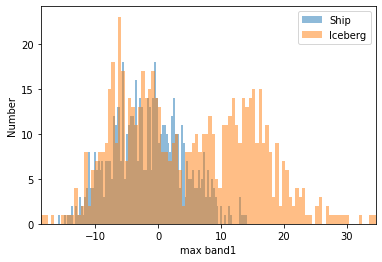

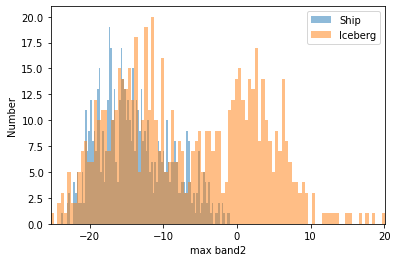

In [20]:
# max band 1
plt.hist(df.loc[df.is_iceberg==1,'max_b1'], bins=100, alpha = 0.5, label='Ship')
plt.hist(df.loc[df.is_iceberg==0,'max_b1'], bins=100, alpha = 0.5, label='Iceberg')
plt.legend()
plt.xlim([df['max_b1'].min(),df['max_b1'].max()])
plt.xlabel('max band1')
plt.ylabel('Number')
plt.show()

# max band 2
plt.hist(df.loc[df.is_iceberg==1,'max_b2'], bins=100, alpha = 0.5, label='Ship')
plt.hist(df.loc[df.is_iceberg==0,'max_b2'], bins=100, alpha = 0.5, label='Iceberg')
plt.legend()
plt.xlim([df['max_b2'].min(),df['max_b2'].max()])
plt.xlabel('max band2')
plt.ylabel('Number')
plt.show()

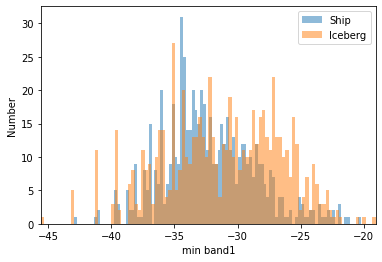

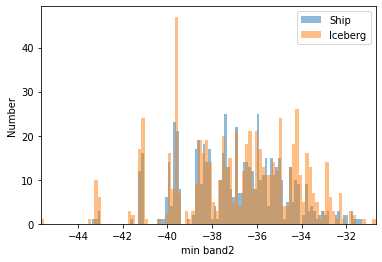

In [21]:
# min band 1
plt.hist(df.loc[df.is_iceberg==1,'min_b1'], bins=100, alpha = 0.5, label='Ship')
plt.hist(df.loc[df.is_iceberg==0,'min_b1'], bins=100, alpha = 0.5, label='Iceberg')
plt.legend()
plt.xlim([df['min_b1'].min(),df['min_b1'].max()])
plt.xlabel('min band1')
plt.ylabel('Number')
plt.show()

# min band 2
plt.hist(df.loc[df.is_iceberg==1,'min_b2'], bins=100, alpha = 0.5, label='Ship')
plt.hist(df.loc[df.is_iceberg==0,'min_b2'], bins=100, alpha = 0.5, label='Iceberg')
plt.legend()
plt.xlim([df['min_b2'].min(),df['min_b2'].max()])
plt.xlabel('min band2')
plt.ylabel('Number')
plt.show()

Applying a FFT (Fast Fourier Transform)

In [32]:
df['fft_b1'] = [np.fft.fft(df.iloc[i][df.columns.get_loc('band_1')]) for i in range(df.shape[0])]
df['fft_b2'] = [np.fft.fft(df.iloc[i][df.columns.get_loc('band_2')]) for i in range(df.shape[0])]

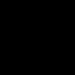

In [30]:
from PIL import Image
import scipy.fftpack as fp

## Functions to go from image to frequency-image and back
im2freq = lambda data: fp.rfft(fp.rfft(data, axis=0),
                               axis=1)
freq2im = lambda f: fp.irfft(fp.irfft(f, axis=1),
                             axis=0)

## Read in data file and transform
data = df['band_1'].iloc[1]

freq = im2freq(data)
back = freq2im(freq)
# Make sure the forward and backward transforms work!
assert(np.allclose(data, back))

## Helper functions to rescale a frequency-image to [0, 255] and save
remmax = lambda x: x/x.max()
remmin = lambda x: x - np.amin(x, axis=(0,1), keepdims=True)
touint8 = lambda x: (remmax(remmin(x))*(256-1e-4)).astype(int)

def arr2im(data, fname):
    out = Image.new('RGB', data.shape[1::-1])
    #out.putdata(map(tuple, data.reshape(-1, 1)))
    out.save(fname)

arr2im(touint8(freq), 'freq.png')
Image.open("freq.png")